# Initialization

并非开始学习的意思。 这个作业的目的是观察 **参数初始化** 的重要性

1. 千万不要将权重参数 $W$ 初始化为0
2. 随机初始化能达到比较好的效果，但是也不能过大。
3. 有一些特殊的初始化方法， 比如除以一个系数，系数与维度相关

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


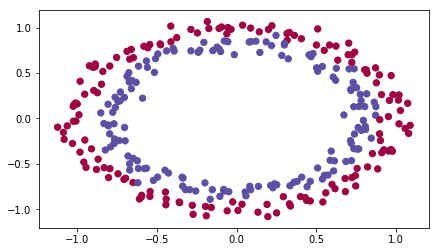

In [2]:
# 准备数据

def load_dataset():
    np.random.seed(1)
    # 生成 圆圈
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

# load image dataset: blue/red dots in circles
train_X, train_Y, test_X, test_Y = load_dataset()

## 1 - Neural Network model 

You will use a 3-layer neural network (already implemented for you). Here are the initialization methods you will experiment with:  
- *Zeros initialization* --  setting `initialization = "zeros"` in the input argument.
- *Random initialization* -- setting `initialization = "random"` in the input argument. This initializes the weights to large random values.  
- *He initialization* -- setting `initialization = "he"` in the input argument. This initializes the weights to random values scaled according to a paper by He et al., 2015. 

**Instructions**: Please quickly read over the code below, and run it. In the next part you will implement the three initialization methods that this `model()` calls.

In [42]:
# 上一次作业里面的各层设计。增加了一些初始化方法

class Layer(object):
    def __init__(self):
        self.X = None
        self.Y = None
        
    def update_paramters(self, learning_rate):
        pass
    
    
class LinearLayer(Layer):
    def __init__(self, n_x, n_y):
        self.X = None
        self.Y = None
        self.init_parameters(n_x, n_y)
        
    def init_parameters(self, n_x, n_y):
        self._init_W(n_x, n_y)
        self.b = np.zeros((n_y, 1))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
    
    def _init_W(self, n_x, n_y):
        self.W = np.zeros((n_y, n_x))
        
    def forward_pass(self, X):
        self.X = X
        self.Y = np.dot(self.W, X) + self.b
        return self.Y
    
    def backward_pass(self, dY):
        m = dY.shape[1]
        self.dW = 1./m * np.dot(dY, self.X.T)
        self.db = 1./m * np.sum(dY, axis = 1, keepdims = True)
        dX = np.dot(self.W.T, dY)
        return dX
    
    def update_paramters(self, learning_rate):
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db
        
        
class SigmoidActivation(Layer):
    
    def forward_pass(self, X):
        self.X = X
        self.Y = 1.0 / (1.0 + np.exp(-X))
        return self.Y
    
    def backward_pass(self, dY):
        return dY * self.Y * (1 - self.Y)
    
    
class ReluActivation(Layer):
    def forward_pass(self, X):
        self.X = X
        self.Y = np.maximum(0, X)
        return self.Y
    
    def backward_pass(self, dY):
        dX = np.array(dY, copy=True)
        dX[self.X <= 0] = 0
        return dX
    

def compute_cost(YP, Y):
    m = Y.shape[1]
    cost = (1./m) * (- np.dot(Y, np.log(YP).T) - np.dot(1-Y, np.log(1-YP).T))
    return np.squeeze(cost)   
    


class SimpleNeuralNetwork(object):
    def __init__(self, layer_dims):
        # layer_dims, output default 1
        layers = []
        n = len(layer_dims)
        for i in range(n-1):
            layers.append(LinearLayer(layer_dims[i], layer_dims[i+1]))
            layers.append(ReluActivation())
        layers[-1] = SigmoidActivation()
        self.layers = layers
        
    def optimize(self, X, Y, learning_rate):
        _X = X
        for l in self.layers:
            _X = l.forward_pass(_X)
        
        cost = compute_cost(_X, Y)
        _dY = - (np.divide(Y, _X) - np.divide(1 - Y, 1 - _X))
        
        # backward
        for l in reversed(self.layers):
            _dY = l.backward_pass(_dY)
            l.update_paramters(learning_rate)
        return cost
    
    def predict(self, X):
        _X = X
        for l in self.layers:
            _X = l.forward_pass(_X)
        return (_X > 0.5).astype(int)
    
    def score(self, X, Y):
        predictions = self.predict(X)
        m = Y.shape[1]
        return predictions, np.sum((predictions == Y)/m)
        

In [43]:

def train_model(X, Y, learning_rate=0.01, num_iterations=15000, print_cost=True):
    m = X.shape[1] # number of examples
    layer_dims = [X.shape[0], 10, 5, 1]
    
    model = SimpleNeuralNetwork(layer_dims)
    costs = []
    
    for i in range(0, num_iterations):
        cost = model.optimize(X, Y, learning_rate)
        # Print the cost every 100 training example
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
            costs.append(cost)
     
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    return model

## 2 - Zero initialization

参数全部初始化为0，则神经网络模型是“对称”的，每个隐藏单元学习到的参数都是一样的。

Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599453
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


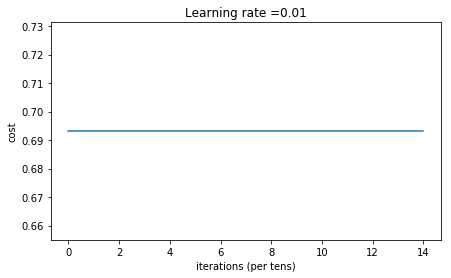

On the train set:  0.5
On the test set:  0.5


In [50]:
def init_zeros(self, n_x, n_y):
    self.W = np.zeros((n_y, n_x))

LinearLayer._init_W = init_zeros

model = train_model(train_X, train_Y)
print ("On the train set: ", model.score(train_X, train_Y)[1])
print ("On the test set: ", model.score(test_X, test_Y)[1])

In [21]:
print(model.layers[0].W)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


(2, 175130)


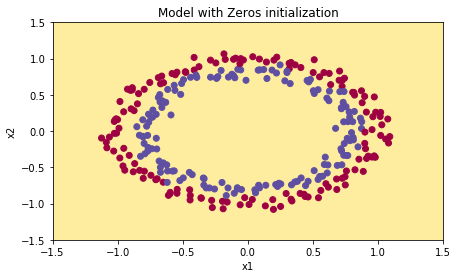

In [29]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    data = np.c_[xx.ravel(), yy.ravel()].T
    print(data.shape)
    Z = model.predict(data)
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()


plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(model, train_X, train_Y)

## 3 - Random initialization


Cost after iteration 0: 1.9698193182646353
Cost after iteration 1000: 0.6894749458317238
Cost after iteration 2000: 0.675058063210226
Cost after iteration 3000: 0.6469210868251528
Cost after iteration 4000: 0.5398790761260324
Cost after iteration 5000: 0.4062642269764849
Cost after iteration 6000: 0.29844708868759456
Cost after iteration 7000: 0.2218373466209485
Cost after iteration 8000: 0.16926424179038072
Cost after iteration 9000: 0.1341330896982709
Cost after iteration 10000: 0.10873865543082417
Cost after iteration 11000: 0.09169443068126974
Cost after iteration 12000: 0.07991173603998081
Cost after iteration 13000: 0.07083949901112582
Cost after iteration 14000: 0.06370209022580518


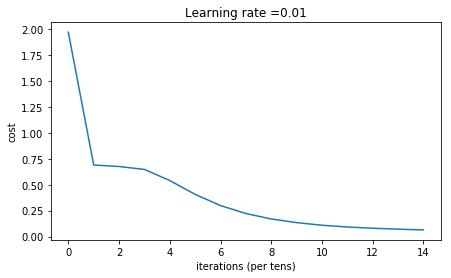

On the train set:  0.996666666667
On the test set:  0.96


In [62]:
def init_random(self, n_x, n_y):
    self.W = np.random.randn(n_y, n_x)

LinearLayer._init_W = init_random

np.random.seed(3)
model = train_model(train_X, train_Y)
print ("On the train set: ", model.score(train_X, train_Y)[1])
print ("On the test set: ", model.score(test_X, test_Y)[1])

(2, 175130)


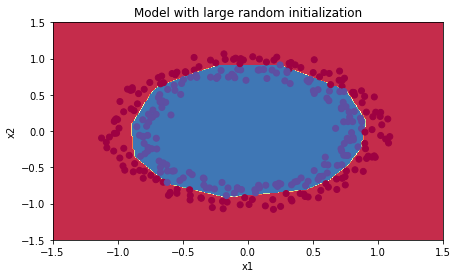

In [55]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(model, train_X, train_Y)

## 4 - He initialization

Finally, try "He Initialization"; this is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

**Exercise**: Implement the following function to initialize your parameters with He initialization.

**Hint**: This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

Cost after iteration 0: 3.866344481386079
Cost after iteration 1000: 0.687346010406377
Cost after iteration 2000: 0.6410028224194565
Cost after iteration 3000: 0.46747180242139597
Cost after iteration 4000: 0.35788914026336954
Cost after iteration 5000: 0.2709685544444085
Cost after iteration 6000: 0.20753508402285287
Cost after iteration 7000: 0.1662101258128594
Cost after iteration 8000: 0.1400818703137909
Cost after iteration 9000: 0.12373782112230426
Cost after iteration 10000: 0.11260964179442255
Cost after iteration 11000: 0.10541712273985733
Cost after iteration 12000: 0.10012078966155612
Cost after iteration 13000: 0.09596531336702699
Cost after iteration 14000: 0.09267664306380641


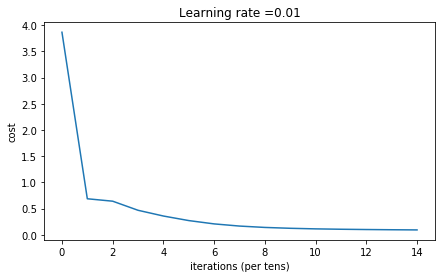

On the train set:  0.98
On the test set:  0.94


In [57]:
def init_he(self, n_x, n_y):
    self.W = np.random.randn(n_y, n_x) / np.sqrt(2./n_x)

LinearLayer._init_W = init_he

# np.random.seed(3)
model = train_model(train_X, train_Y)
print ("On the train set: ", model.score(train_X, train_Y)[1])
print ("On the test set: ", model.score(test_X, test_Y)[1])

(2, 175130)


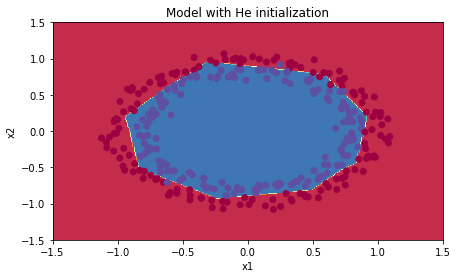

In [58]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(model, train_X, train_Y)

## 5 - Conclusions

You have seen three different types of initializations. For the same number of iterations and same hyperparameters the comparison is:

<table> 
    <tr>
        <td>
        **Model**
        </td>
        <td>
        **Train accuracy**
        </td>
        <td>
        **Problem/Comment**
        </td>

    </tr>
        <td>
        3-layer NN with zeros initialization
        </td>
        <td>
        50%
        </td>
        <td>
        fails to break symmetry
        </td>
    <tr>
        <td>
        3-layer NN with large random initialization
        </td>
        <td>
        99%
        </td>
        <td>
        too large weights 
        </td>
    </tr>
    <tr>
        <td>
        3-layer NN with He initialization
        </td>
        <td>
        98%
        </td>
        <td>
        recommended method
        </td>
    </tr>
</table> 

<font color='blue'>
**What you should remember from this notebook**:
- Different initializations lead to different results
- Random initialization is used to break symmetry and make sure different hidden units can learn different things
- Don't intialize to values that are too large
- He initialization works well for networks with ReLU activations. 